In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# define dataset

from scipy.io import arff
from pandas.api.types import is_string_dtype, is_numeric_dtype

FLCHAIN_URL = 'https://raw.githubusercontent.com/sebp/scikit-survival/master/sksurv/datasets/data/flchain.arff'

import io
import requests

data, meta = arff.loadarff(io.StringIO(requests.get(FLCHAIN_URL).content.decode('utf-8')))
df = pd.DataFrame(data).apply(lambda x: x.str.decode('utf-8').astype('category') if is_string_dtype(x) else x)

df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97.0,F,1997,5.700,4.860,10,1.7,no,85.0,dead,Circulatory
1,92.0,F,2000,0.870,0.683,1,0.9,no,1281.0,dead,Neoplasms
2,94.0,F,1997,4.360,3.850,10,1.4,no,69.0,dead,Circulatory
3,92.0,F,1996,2.420,2.220,9,1.0,no,115.0,dead,Circulatory
4,93.0,F,1996,1.320,1.690,6,1.1,no,1039.0,dead,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52.0,F,1995,1.210,1.610,6,1.0,no,4997.0,alive,?
7870,52.0,F,1999,0.858,0.581,1,0.8,no,3652.0,alive,?
7871,54.0,F,2002,1.700,1.720,8,NaN,no,2507.0,alive,?
7872,53.0,F,1995,1.710,2.690,9,NaN,no,4982.0,alive,?


In [3]:
t = df['futime'].values
s = (df['death'] == 'dead').astype(float).values

X = pd.get_dummies(df.drop(['futime', 'death'], axis=1))
X = ((X - X.mean()) / X.std()).fillna(0).values

print(t.shape, s.shape, X.shape)

(7874,) (7874,) (7874, 44)


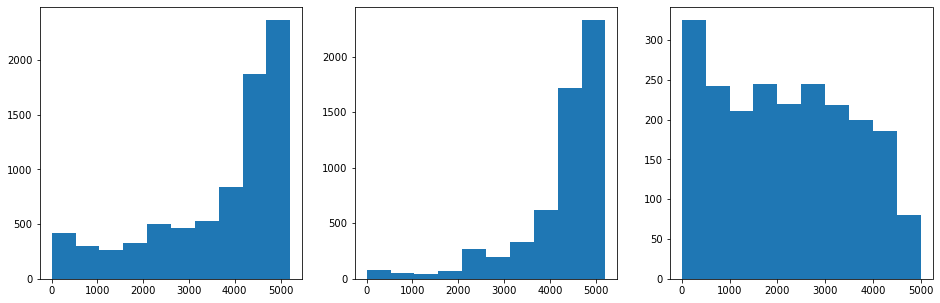

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].hist(t)
ax[1].hist(t[s == 0])
ax[2].hist(t[s == 1])
plt.show()

In [5]:
N_FEATURES = X.shape[1]
N_REPRESENTATION = N_FEATURES

N_TIME_BUCKETS = 10

t = (N_TIME_BUCKETS * t / (t.max() + 1)) // 1

print(*np.unique(t, return_counts=True))

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [ 414  300  265  326  496  469  532  843 1871 2358]


In [6]:
# Maximum Mean Discrepancy

def gaussian_kernel(a, b):
    dim1_1, dim1_2 = a.shape[0], b.shape[0]
    depth = a.shape[1]
    a = a.view(dim1_1, 1, depth)
    b = b.view(1, dim1_2, depth)
    a_core = a.expand(dim1_1, dim1_2, depth)
    b_core = b.expand(dim1_1, dim1_2, depth)
    numerator = (a_core - b_core).pow(2).mean(2)/depth
    return torch.exp(-numerator)

def MMD(a, b):
    return gaussian_kernel(a, a).mean() + gaussian_kernel(b, b).mean() - 2*gaussian_kernel(a, b).mean()

In [7]:
# Negative Log Likelihood

def nlpl(f, g, t, s): # negative log partial likelihood
    F = torch.cumsum(f, 1)
    G = torch.cumsum(g, 1)
    ll = s * torch.gather(torch.log(f) + torch.log(G), 1, t.view(-1, 1)).squeeze()
    ll += (1 - s) * torch.gather(torch.log(F) + torch.log(g), 1, t.view(-1, 1)).squeeze()
    return -1 * ll

In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def MLP(layer_sizes, activation_fn=nn.Sigmoid()):
    assert len(layer_sizes) > 1
    layers = []
    for i, (pls, cls) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layers.append(nn.Linear(pls, cls))
        layers.append(activation_fn)
    return nn.Sequential(*layers)

# Define model
class UTTE(nn.Module):
    
    def __init__(self):
        super(UTTE, self).__init__()
        self.phi_mlp = MLP([N_FEATURES, N_REPRESENTATION])
        self.gamma_mlp = MLP([N_FEATURES, N_REPRESENTATION])
        self.f_mlp = MLP([N_REPRESENTATION, N_TIME_BUCKETS], activation_fn=nn.Softmax(1))
        self.g_mlp = MLP([N_REPRESENTATION, N_TIME_BUCKETS], activation_fn=nn.Softmax(1))

    def forward(self, x):
        self.phi = self.phi_mlp(x)
        self.gamma = self.gamma_mlp(x)
        self.f = self.f_mlp(self.phi)
        self.g = self.g_mlp(self.gamma)
        return self.f, self.g
    
    def loss(self, x, t, s, alpha=0.5):
        self.forward(x)
        self.mmd = MMD(self.phi[s.bool(), :], self.phi[(1 - s).bool(), :])
        self.nll = nlpl(self.f, self.g, t, s).mean()
        return alpha * self.nll + (1 - alpha) * self.mmd

model = UTTE().to(device)

Using cpu device


In [9]:
model.loss(torch.randn(100, 44), torch.randint(0, 10, (100, )), torch.randint(0, 2, (100, )), alpha=.5)

tensor(1.5151, grad_fn=<AddBackward0>)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def batch(*arrs, n=1):
    l = len(arrs[0])
    for ndx in range(0, l, n):
        yield (arr[ndx:min(ndx + n, l)] for arr in arrs)

In [12]:
# TRAIN

N_EPOCHS = 20

for epoch_idx in range(N_EPOCHS):

    for i, (batch_X, batch_t, batch_s) in enumerate(batch(X, t, s, n=100)):
        
        #print(batch_X.shape, batch_t.shape, batch_s.shape)

        batch_X = torch.tensor(batch_X, dtype=torch.float32)
        batch_t = torch.tensor(batch_t, dtype=torch.int64)
        batch_s = torch.tensor(batch_s, dtype=torch.int64)

        # Compute prediction error
        loss = model.loss(batch_X, batch_t, batch_s)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            loss, current = loss.item(), i * len(batch_X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(X):>5d}]")

loss: 1.862756  [    0/ 7874]
loss: 1.783952  [    0/ 7874]
loss: 1.572179  [    0/ 7874]
loss: 1.357856  [    0/ 7874]
loss: 1.188244  [    0/ 7874]
loss: 1.092472  [    0/ 7874]
loss: 1.049673  [    0/ 7874]
loss: 1.031311  [    0/ 7874]
loss: 1.021888  [    0/ 7874]
loss: 1.015370  [    0/ 7874]
loss: 1.009742  [    0/ 7874]
loss: 1.004375  [    0/ 7874]
loss: 0.999089  [    0/ 7874]
loss: 0.993892  [    0/ 7874]
loss: 0.988792  [    0/ 7874]
loss: 0.983779  [    0/ 7874]
loss: 0.978839  [    0/ 7874]
loss: 0.973963  [    0/ 7874]
loss: 0.969153  [    0/ 7874]
loss: 0.964413  [    0/ 7874]


In [13]:
# TEST

## Discussion with Ricardo

- Scale of MMD
- Should we go back to AFT or stick with nonparametric
- If nonparametric, evaluation metrics? -> Still need the usual ones
- Recommended datasets

- optimize cross-entropy loss on multiple time scales -> this may be more relevant to the other paper
- in other words can aggregate across multiple buckets
----
- discretization can be by e.g. deciles rather than uniform in time
----
- one way to add contrastive learning: pick other examples with event times before the current one. Can be just one additional objective -> this adds additional interest to current paper
- just use standard objective, but enforce order with contrastive learning
- for each example, select another example where the event happens in the bucket before; for every observation, pick someone in the bucket (a) before, and (b) after

- if the censoring part works -- and should be easy to implement -- we might be able to connect it to the way people usually do it for informative censoring